### Step 1-1. 從Tarflow下載資料
+ 資料來源：PTT - 八卦版
+ 資料時間範圍：2022/03/21 - 2024/03/21
+ 搜尋關鍵字：台電、台灣電力、電費、電價
+ 排除關鍵字：
+ 文章總數：5381篇
<!-- + 搜尋關鍵字：台電漲、台電調漲、電費調漲、電費漲、電價調漲、電價漲、漲電 -->

In [1]:
#使用套件預載
import pandas as pd
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] 

# 設定文字雲中文字體路徑 金萱粉圓體2.0
FontPath = 'path/to/jf-openhuninn-2.0.ttf' # 設定字型
# FontPath = './SourceHanSansTW-Regular.otf' # 設定字型

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

### Step 1-2.將下載的檔案載入環境

In [3]:
raw_data = pd.read_csv('./Taipower230321_240321.csv')
raw_data["artDate"] = pd.to_datetime(raw_data["artDate"])
raw_data['artDate'] = raw_data['artDate'].dt.date 

### Step 1-3.資料清理

In [4]:
clear_data = raw_data.copy()

#去除本次不會用到的欄位
drop_cols = ['artUrl', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_data.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_data.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_data['sentence'] = clear_data['artContent'].str.replace(r'\n\n','。', regex=True)
clear_data['sentence'] = clear_data['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_data['sentence'] = clear_data['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_data.head()

,system_id,artTitle,artDate,artContent,sentence
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,電是用納稅人繳的錢發的。但是党說台電自行把電藏起來。是否應該用非法侵占國有財產罪來法辦這些涉...
1,2,[問卦]誰不喜歡用便宜的電吃便宜的蛋,2023-03-21,餓死抬頭\n最近看到不少奇怪言論\n像是台灣電價太便宜、缺蛋？還是缺錢？\n肥宅活到快30才...,餓死抬頭，最近看到不少奇怪言論，像是台灣電價太便宜、缺蛋？還是缺錢？，肥宅活到快30才知道，...
2,3,[問卦]風力0.05%？晚上90%的發電靠燃氣/,2023-03-21,https://i.imgur.com/lGzIICD.jpg\n半夜看空氣霧霧的，想說一定...,發電量是靠燒媒、燒氣…。風力 0.05% ？？？？？？？？？。看來核三除役後，燒東西發電會...
3,4,[問卦]有錢發給民眾怎麼不多蓋電廠？,2023-03-21,看外國蓋核電廠大概六百億\n\n全民發六千可以蓋兩座核電廠還有剩\n\n剩下的錢拿來蓋國營雞...,看外國蓋核電廠大概六百億。全民發六千可以蓋兩座核電廠還有剩。剩下的錢拿來蓋國營雞場不好嗎？。...
4,5,[問卦]有沒有抗了通膨還贏了健康的八卦?,2023-03-21,我同事號稱人體抗通膨專家。\n\n外食價格上漲，他索性不吃晚餐，\n\n原本有點微胖的他，現...,我同事號稱人體抗通膨專家。。外食價格上漲，他索性不吃晚餐，。原本有點微胖的他，現在居然被工讀...


### Step 1-4. 進行斷句處理


In [5]:
clear_data['sentence'] = clear_data['sentence'].str.split("[,，。！!？?]{1,}")

Sent_Seg_data = clear_data.explode('sentence').reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
Sent_Seg_data['sentence'] = Sent_Seg_data['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
Sent_Seg_data = Sent_Seg_data[Sent_Seg_data["sentence"].str.len() > 1]

Sent_Seg_data

,system_id,artTitle,artDate,artContent,sentence
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,電是用納稅人繳的錢發的
1,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,但是党說台電自行把電藏起來
2,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,是否應該用非法侵占國有財產罪來法辦這些涉嫌藏電的台電員工
4,2,[問卦]誰不喜歡用便宜的電吃便宜的蛋,2023-03-21,餓死抬頭\n最近看到不少奇怪言論\n像是台灣電價太便宜、缺蛋？還是缺錢？\n肥宅活到快30才...,餓死抬頭
5,2,[問卦]誰不喜歡用便宜的電吃便宜的蛋,2023-03-21,餓死抬頭\n最近看到不少奇怪言論\n像是台灣電價太便宜、缺蛋？還是缺錢？\n肥宅活到快30才...,最近看到不少奇怪言論
...,...,...,...,...,...
185115,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,沒關係阿
185116,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,在下次降息前我都會一直拿這一篇問你的
185117,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,你以為不升就沒有問題嗎
185118,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,這麼簡單的話全球央行全部降息不就好了


### Step 1-5. 進行斷詞處理

In [6]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('./dict/dict.txt')
jieba.load_userdict('./dict/user_dict.txt')
jieba.add_word('用愛發電')


Tokenisation_data = Sent_Seg_data.assign(word = Sent_Seg_data['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
Tokenisation_data = Tokenisation_data.loc[Tokenisation_data['word'].str.len() > 1]

Tokenisation_data


Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/Team-8-Project/dict/dict.txt ...
Dumping model to file cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.u55c659e75cba201259bad053b49d2172.cache
Loading model cost 0.277 seconds.
Prefix dict has been built successfully.


,system_id,artTitle,artDate,artContent,word
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,電是
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,納稅人
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,繳的
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,錢發
1,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,但是
...,...,...,...,...,...
185118,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,降息
185118,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,好了
185119,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,一下
185119,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,腦子


### Step 1-6.移除停用字

In [7]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('./dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["新聞","現在","今年","完整","表示","影響","記者","問題","去年","產業","國際","億元","10","平均","以下","來源","報導","指出","知道","每度","20","未來","目前","超過"]
stopwords_manual_2 = ["決定","希望","安全","重要","相信","保證","確定","簡單","願意","八卦","風險"]
stopwords.extend(stopwords_manual)
stopwords.extend(stopwords_manual_2)

noStopword_data = Tokenisation_data[~Tokenisation_data['word'].isin(stopwords)]
noStopword_data

,system_id,artTitle,artDate,artContent,word
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,電是
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,納稅人
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,繳的
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,錢發
1,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,台電
...,...,...,...,...,...
185118,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,央行
185118,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,降息
185118,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,好了
185119,5381,Re:[問卦]升息是國際公認降物價的方式,2024-03-21,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,一下


### Step 1-7.繪製長條圖，看資料有沒有需要進一步調整停用字

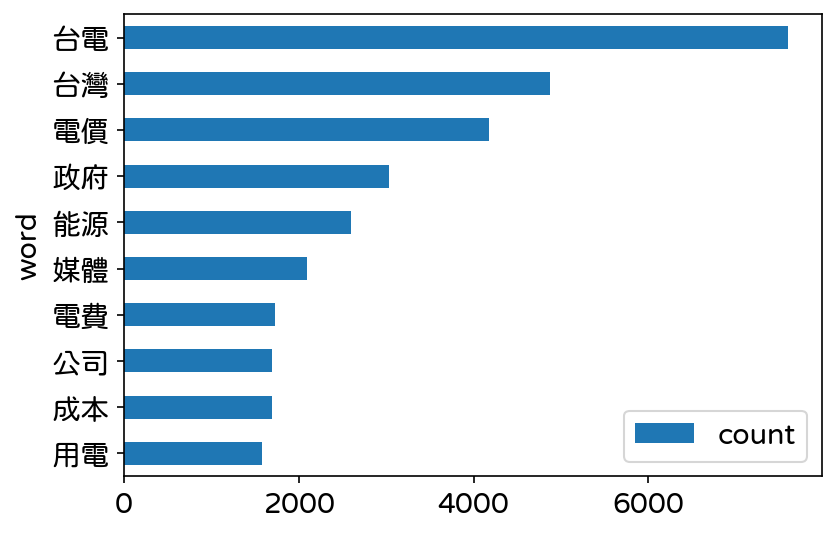

In [8]:
barplot_data = pd.DataFrame(pd.value_counts(noStopword_data['word'])).reset_index()
barplot_data.columns = ['word','count']
barplot_data = barplot_data.sort_values(by = 'count', ascending = False).reset_index(drop = True)

barplot_data.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()


### Step 1-8. 確認斷詞是否有誤斷的字，若有則調整斷詞字典

In [9]:
noStopword_data[noStopword_data['word'] == ('用愛發電')]['word'].count()
# Sent_Seg_data[Sent_Seg_data['sentence'].str.contains('用愛發電')]['sentence'].count()


70

### Step 1-9. 繪製文字雲

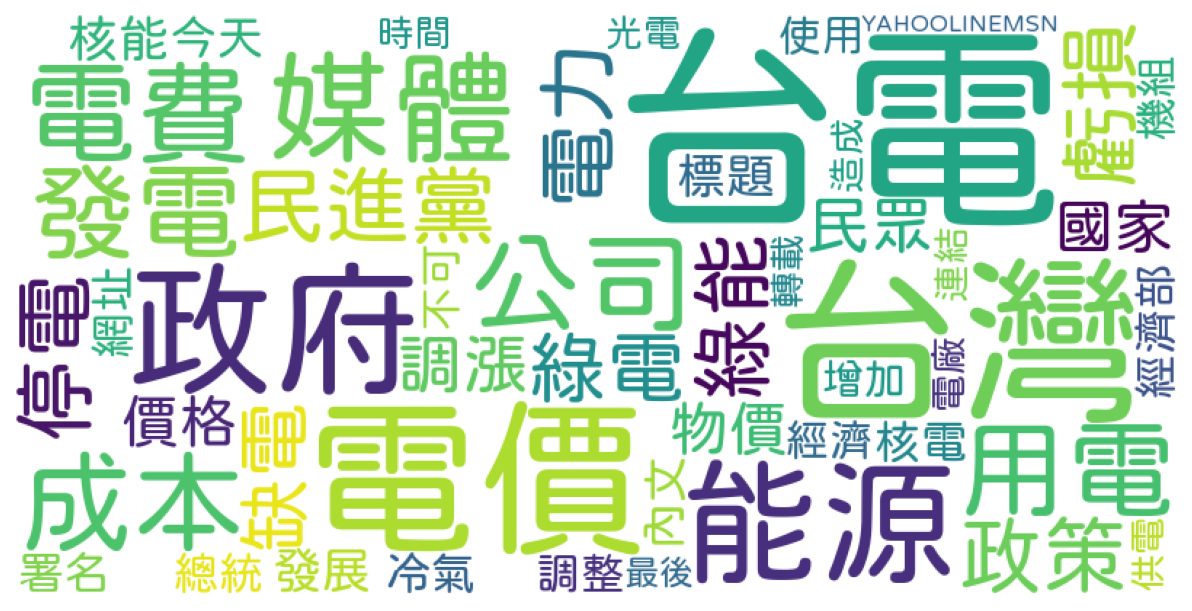

In [10]:
noStopword_wordcloud = barplot_data.set_index('word').to_dict()
noStopword_wordcloud = noStopword_wordcloud['count']

# 繪製文字雲
wordcloud = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(noStopword_wordcloud)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Step 2-1. 準備LIWC字典

In [11]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [12]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

### Step 2-2. 與上方整理好的資料集合併

In [13]:
sentiment_liwc_data = pd.merge(noStopword_data[["system_id", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
sentiment_liwc_data

,system_id,artDate,artTitle,artContent,word,sentiments
0,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,電是,NaN
1,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,納稅人,NaN
2,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,繳的,NaN
3,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,錢發,NaN
4,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,台電,NaN
...,...,...,...,...,...,...
613673,5381,2024-03-21,Re:[問卦]升息是國際公認降物價的方式,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,央行,NaN
613674,5381,2024-03-21,Re:[問卦]升息是國際公認降物價的方式,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,降息,NaN
613675,5381,2024-03-21,Re:[問卦]升息是國際公認降物價的方式,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,好了,NaN
613676,5381,2024-03-21,Re:[問卦]升息是國際公認降物價的方式,但很可惜台灣目前就是進退兩難\n\n正常情況就是該升息的時候就要升該降得時候降\n\n這樣你...,一下,NaN


### Step 2-3-1. 統計沒有被LIWC統計到的字，確認是否手動加進LIWC字典內

In [14]:
sentiment_liwc_data['sentiments'] = sentiment_liwc_data['sentiments'].fillna("NULL")

NaN_sentiment_count = pd.DataFrame(
    sentiment_liwc_data.groupby(["word", "sentiments"]).size()
).reset_index()

NaN_sentiment_count = NaN_sentiment_count[NaN_sentiment_count['sentiments'] == "NULL"]
NaN_sentiment_count = NaN_sentiment_count.rename(columns={0: "size"})
NaN_sentiment_count = NaN_sentiment_count.sort_values(["size"], ascending = False)

# NaN_sentiment_count.to_csv("NaN_sentiment_count.csv", index=False)
NaN_sentiment_count


,word,sentiments,size
18663,台電,NULL,7606
18600,台灣,NULL,4877
60306,電價,NULL,4178
32751,政府,NULL,3028
48791,能源,NULL,2596
...,...,...,...
32227,擠到,NULL,1
32230,擠得,NULL,1
32237,擦地,NULL,1
32238,擦布,NULL,1


In [15]:
#手動新增單字的情緒類別

# Sent_Seg_data[Sent_Seg_data['sentence'].str.contains('節能')]['sentence']

NaN_sentiment_count.loc[NaN_sentiment_count['word'] == '漲價', 'sentiments'] = 'negative'
NaN_sentiment_count.loc[NaN_sentiment_count['word'] == '缺電', 'sentiments'] = 'negative'
NaN_sentiment_count.loc[NaN_sentiment_count['word'] == '通膨', 'sentiments'] = 'negative'
NaN_sentiment_count.loc[NaN_sentiment_count['word'] == '加漲', 'sentiments'] = 'positive'
NaN_sentiment_count.loc[NaN_sentiment_count['word'] == '便宜', 'sentiments'] = 'positive'
NaN_sentiment_count.loc[NaN_sentiment_count['word'] == '凍漲', 'sentiments'] = 'positive'
NaN_sentiment_count.loc[NaN_sentiment_count['word'] == '補貼', 'sentiments'] = 'positive'
NaN_sentiment_count.loc[NaN_sentiment_count['word'] == '補助', 'sentiments'] = 'positive'
NaN_sentiment_count = NaN_sentiment_count.drop(columns=['size'])


NaN_sentiment_count = NaN_sentiment_count[NaN_sentiment_count['sentiments'] != "NULL"]
NaN_sentiment_count

# 將字新增至 liwc_dict 當中
liwc_dict = pd.concat([liwc_dict, NaN_sentiment_count], ignore_index=True)
#將特定字修改情緒詞性
liwc_dict.loc[liwc_dict['word'] == '笑死', 'sentiments'] = 'negative'
# print(liwc_dict.loc[liwc_dict['word'] == '補貼'])

#並且重新透過liwc將情緒字合併至sentiment_liwc_data
sentiment_liwc_data = pd.merge(noStopword_data[["system_id", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")


### Step 2-3. 統計正向情緒與負向情緒數量

In [16]:
sentiment_count = pd.DataFrame(
    sentiment_liwc_data.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
3,2023-03-21,negative,202
4,2023-03-21,positive,159
9,2023-03-22,negative,111
10,2023-03-22,positive,94
15,2023-03-23,negative,119
...,...,...,...
1976,2024-03-19,positive,39
1981,2024-03-20,negative,99
1982,2024-03-20,positive,112
1987,2024-03-21,negative,160


### Step 2-4. 繪製正負情緒詞彙頻率折線圖

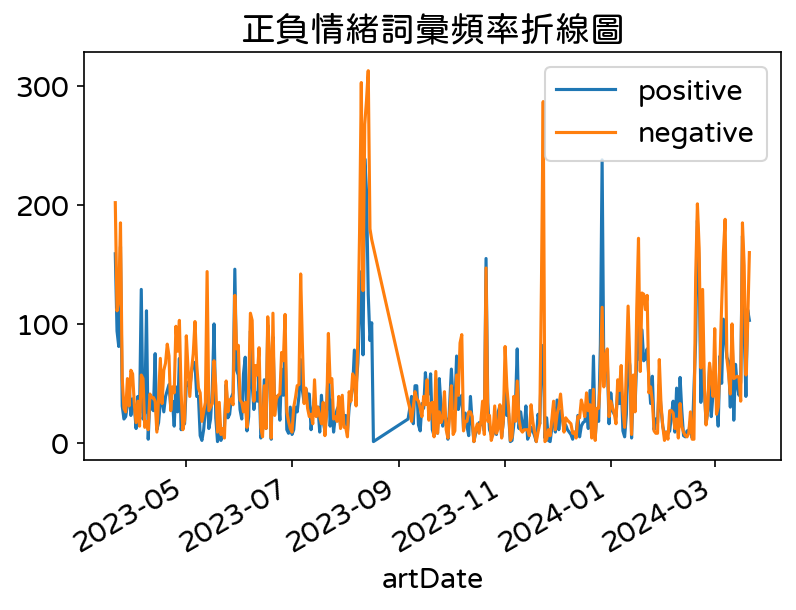

In [17]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖")  # 記得加上才能顯示中文
plt.show()

### Step 2-4. 繪製正負情緒詞彙頻率折線圖 + Moving average

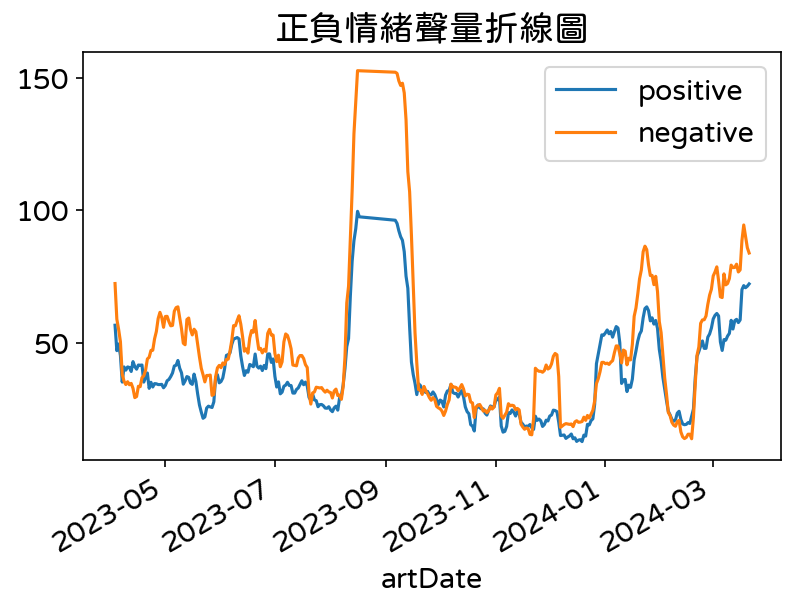

In [18]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖")
plt.show()

### Step 2-5. 正負向情緒分數折線圖

In [19]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2023-03-21,202,159,-43
1,2023-03-22,111,94,-17
2,2023-03-23,119,81,-38
3,2023-03-24,185,165,-20
4,2023-03-25,54,31,-23


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

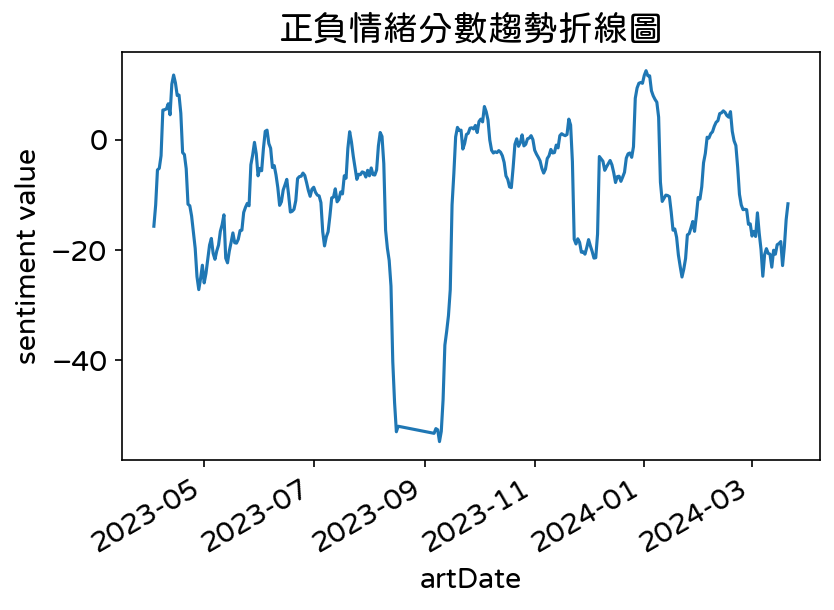

In [20]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### Step 2-6 以文章為單位的情緒分析

In [21]:
#將資料以system_id, 情緒類別進行分群，並將產生size()計算書量
sentiment_count_by_article = pd.DataFrame(
    sentiment_liwc_data.groupby(["system_id", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})

#長資料轉換成寬資料
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="system_id", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

#計算sentiment value 每篇文章的情緒值
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
#計算完後，負的值為負向，正的值為正向
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article


,system_id,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,2,5,2,0,3,3,0,0,負向
1,4,2,0,0,1,1,0,0,負向
2,5,1,0,0,2,1,0,-1,負向
3,6,11,0,0,0,7,0,7,正向
4,7,8,1,1,6,4,1,-2,負向
...,...,...,...,...,...,...,...,...,...
4470,5376,15,0,0,11,4,10,-7,負向
4471,5377,1,0,1,1,2,0,1,正向
4472,5379,1,0,0,1,0,0,-1,負向
4473,5380,3,0,0,1,2,0,1,正向


In [22]:
#原始乾淨的資料進行合併，新增欄位Sentiment_class
clear_data_sentiment_calss = pd.merge(clear_data, ptt_sentiment_value_by_article[['system_id', 'sentiment_class']], how="left")
clear_data_sentiment_calss.head()

,system_id,artTitle,artDate,artContent,sentence,sentiment_class
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,"[電是用納稅人繳的錢發的, 但是党說台電自行把電藏起來, 是否應該用非法侵占國有財產罪來法辦...",NaN
1,2,[問卦]誰不喜歡用便宜的電吃便宜的蛋,2023-03-21,餓死抬頭\n最近看到不少奇怪言論\n像是台灣電價太便宜、缺蛋？還是缺錢？\n肥宅活到快30才...,"[餓死抬頭, 最近看到不少奇怪言論, 像是台灣電價太便宜、缺蛋, 還是缺錢, 肥宅活到快30...",負向
2,3,[問卦]風力0.05%？晚上90%的發電靠燃氣/,2023-03-21,https://i.imgur.com/lGzIICD.jpg\n半夜看空氣霧霧的，想說一定...,"[ 發電量是靠燒媒、燒氣…, 風力 0.05% , 看來核三除役後, 燒東西發電會上看 95...",NaN
3,4,[問卦]有錢發給民眾怎麼不多蓋電廠？,2023-03-21,看外國蓋核電廠大概六百億\n\n全民發六千可以蓋兩座核電廠還有剩\n\n剩下的錢拿來蓋國營雞...,"[看外國蓋核電廠大概六百億, 全民發六千可以蓋兩座核電廠還有剩, 剩下的錢拿來蓋國營雞場不好...",負向
4,5,[問卦]有沒有抗了通膨還贏了健康的八卦?,2023-03-21,我同事號稱人體抗通膨專家。\n\n外食價格上漲，他索性不吃晚餐，\n\n原本有點微胖的他，現...,"[我同事號稱人體抗通膨專家, 外食價格上漲, 他索性不吃晚餐, 原本有點微胖的他, 現在居然...",負向


In [23]:
#依文章日期與情緒類別進行分組，並產生size()計算數量
sentiment_article_count = pd.DataFrame(
    clear_data_sentiment_calss.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_article_count = sentiment_article_count.rename(columns={0: "size"})
sentiment_article_count = sentiment_article_count.sort_values(["artDate"])
sentiment_article_count

# sentiment_article_count.to_csv("sentiment_article_count.csv", index=False)
sentiment_article_count


,artDate,sentiment_class,size
0,2023-03-21,正向,10
1,2023-03-21,負向,19
2,2023-03-22,正向,15
3,2023-03-22,負向,17
4,2023-03-23,正向,10
...,...,...,...
656,2024-03-19,負向,15
657,2024-03-20,正向,15
658,2024-03-20,負向,16
659,2024-03-21,正向,13


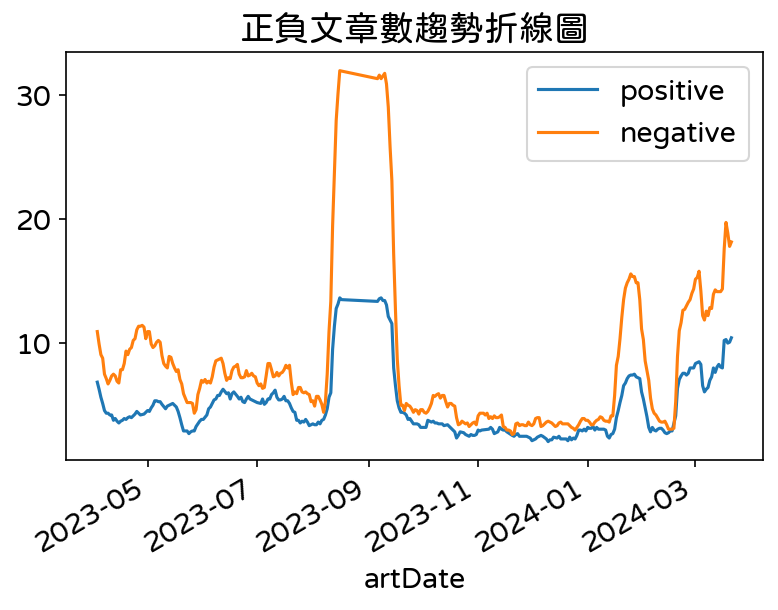

In [24]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_article_count[sentiment_article_count["sentiment_class"] == "正向"]
neg = sentiment_article_count[sentiment_article_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")  # 記得加上才能顯示中文
plt.show()

### Step 2-7. 計算情緒代表字

In [25]:
#將處理完斷字與liwc進行合併的資料，重新依照word, sentiments分組並計算數量
sentiment_word_count = sentiment_liwc_data.groupby(["word", "sentiments"]).size().reset_index()
sentiment_word_count = sentiment_word_count.rename(columns={0: "size"})
sentiment_word_count = sentiment_word_count.sort_values(["size"], ascending=False)

#計算正向的情緒代表字數量
sentiment_word_pos = sentiment_word_count[sentiment_word_count["sentiments"] == "positive"]
sentiment_word_pos

,word,sentiments,size
182,便宜,positive,640
2292,補助,positive,557
1349,支持,positive,506
2307,解決,positive,485
2293,補貼,positive,449
...,...,...,...
1133,慶賀,positive,1
1119,感興趣,positive,1
1107,愛慕,positive,1
967,忠孝,positive,1


In [26]:
#計算負向的情緒代表字數量
sentiment_word_neg = sentiment_word_count[sentiment_word_count["sentiments"] == "negative"]
sentiment_word_neg.head(15)

,word,sentiments,size
2267,虧損,negative,1415
2086,缺電,negative,1232
1667,漲價,negative,636
2483,通膨,negative,552
1186,戰爭,negative,365
622,嚴重,negative,361
1385,故障,negative,311
108,事故,negative,286
2571,降低,negative,283
666,壓力,negative,272


/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/3262306637.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/3262306637.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

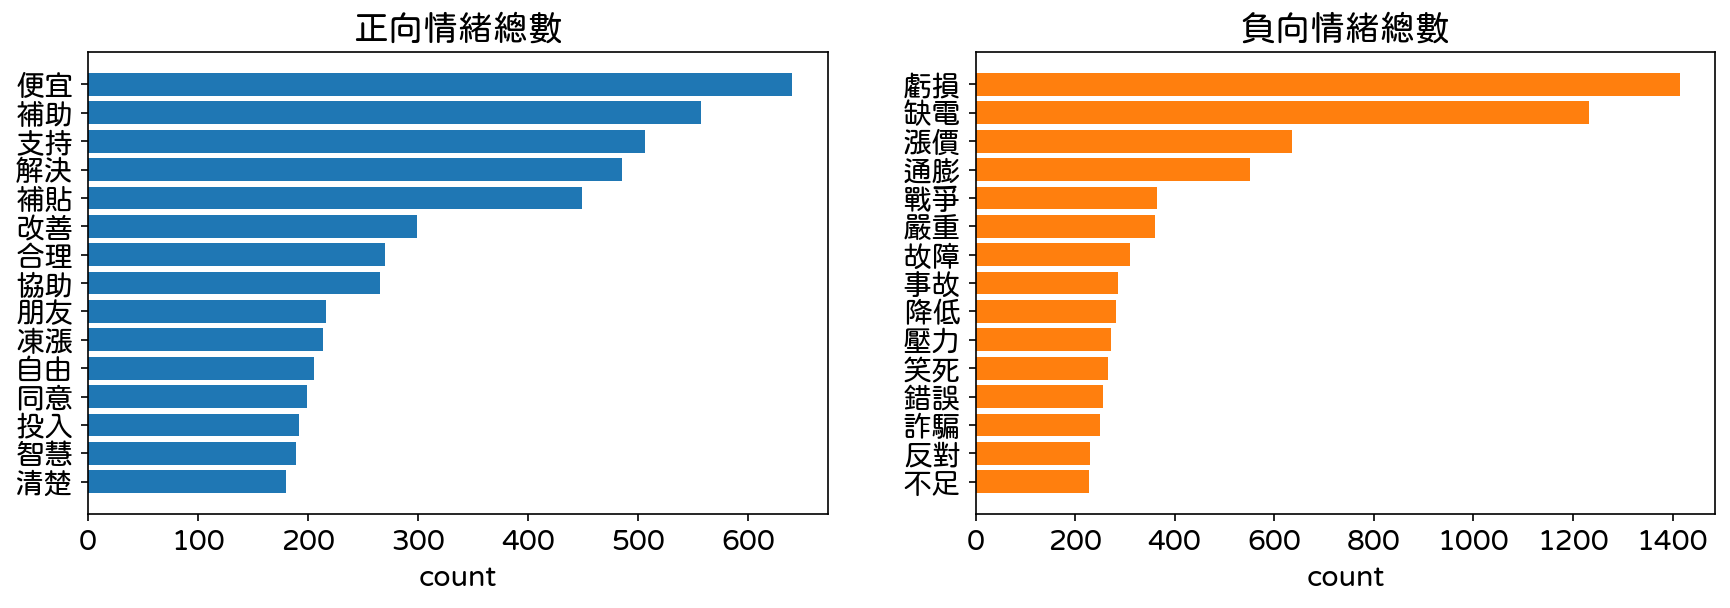

In [27]:
pos = sentiment_word_pos.head(15).sort_values(["size"], ascending=True)
neg = sentiment_word_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=150)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

### Step 2-8. 檢查該情緒字是否符合本文的情緒

In [28]:
# 調出特定情緒字的句子
check_sentence = Sent_Seg_data[Sent_Seg_data['sentence'].str.contains('笑死', na=False)]
for sentence in check_sentence['sentence'].to_list():
    print(sentence)
    print("=========================")

#回到Step 2-3-1 將笑死的情緒由positive -> negative

笑死
笑死
笑死
笑死
笑死了 台灣價值呢 搞了半天台灣價值是有人去就可以
笑死
笑死
是笑死人
真的笑死人
笑死人
 結果不要臉的政客說是適溫推廣 笑死
就 缺電啊 笑死
笑死
笑死掏空台灣讓台灣弱化比較可能啦
笑死
我真的快笑死 人民有知的權利在民主國家是天經地義
真是笑死耶
一堆傻子以為政府加薪 房價砍半 人人年薪百萬有房 就可以買到台女子宮 笑死
 笑死
笑死 邏輯完全不通
笑死人
 笑死 棒球場的照明就抵掉籃球場總額的電費吧
建商以後吊臂愛怎麼丟就怎麼丟還是小事 變成台灣人應該要習慣的日常 笑死
真的笑死
笑死
我他媽快笑死
緊急的時候 趕著用 都突然不怕會出事了 笑死
笑死人繼續爽挖
笑死
笑死人
笑死 你們大DPP才是有如土匪首領好嘛
怪囉 柯先把他要用誰先說出來 也會被說威權XD 真他媽笑死
笑死人罵綠的被逼關臉書的跟被出征的有幾件
笑死人真的
笑死
他媽的笑死
不要笑死人了
笑死 現在還看不出來民進黨執政能力的根本就是白癡
不被笑死才怪
哈哈哈 笑死
幹他媽真的笑死
笑死 物價全部漲一波了
不去還會被靠杯勒 笑死人的南部鄉鎮
那就笑死寶寶了
笑死
 笑死
柯粉又翻車 笑死
 笑死
要不要笑死人
笑死
勤政清廉愛鄉土笑死
阿肥我北漂多年卻離買房越來越遠笑死qq
笑死
笑死
要小心中暑笑死
笑死    
笑死人
政府整天躲在側翼後面放話真的笑死人
笑死黑金會介入的產業特性就是不用什麼
笑死
笑死
笑死 這樣以後有答案可以抄了啦
笑死
笑死
真是笑死寶寶了
笑死
笑死
笑死怪東怪西怪別人囉
        笑死  真的是兩共一家親  都在造假數據  粉飾太平
笑死 FB還有聖人在那邊幫台電人員說話
不必去擔心會不會有一天看到中東油田挖完窮死而笑死
笑死
笑死
還說備載電力太高 是弊案  笑死
然後還順利取得了政府的甚麼優良社區評比根本笑死
 笑死
笑死
笑死
笑死  當然現在不做阿
笑死又柯粉
  笑死
   何況學費早就有在漲  一堆柯粉不去查證就說沒漲  笑死
笑死耶
電量不足以讓民眾開暖氣 笑死
笑死誰啊
笑死
真的要笑死
笑死
笑死
笑死
笑死人了
然後塔綠斑好意思 罵當初馬英九的油電雙漲 笑死
笑死
真的快笑死
笑死
備註裡的yt連結裡的嘴臉 真的是笑死
笑死
真的是會把人笑死
笑死
笑死人了
真的快笑死XD
笑死
你連人家射了哪些地區都不懂笑

### Step 2-9. 放大特定區間資料
<!-- + 2022/06/19-2022/07/04 資料異常大量負面評價
+ 2023/03/13-2023/03/24 資料異常大量負面評價
+ 2024/02/19-2024/03/21 資料異常大量負面評價 -->
+ 2023/08/08 - 2023/08/16

In [29]:
#將每一篇「文章」標記是正面文章還是負面文章
specific_date_sentiment_liwc_data = pd.merge(sentiment_liwc_data, ptt_sentiment_value_by_article[['system_id', 'sentiment_class']], how="left")
specific_date_sentiment_liwc_data.head()

,system_id,artDate,artTitle,artContent,word,sentiments,sentiment_class
0,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,電是,NaN,NaN
1,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,納稅人,NaN,NaN
2,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,繳的,NaN,NaN
3,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,錢發,NaN,NaN
4,1,2023-03-21,[問卦]台電藏電是不是觸犯法律？,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,台電,NaN,NaN


In [30]:
#標記每一個「句子」對應到原始文章是正面文章還是負面文章
Sent_Seg_data = pd.merge(Sent_Seg_data, ptt_sentiment_value_by_article[['system_id', 'sentiment_class']], how="left")
Sent_Seg_data.head()

,system_id,artTitle,artDate,artContent,sentence,sentiment_class
0,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,電是用納稅人繳的錢發的,NaN
1,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,但是党說台電自行把電藏起來,NaN
2,1,[問卦]台電藏電是不是觸犯法律？,2023-03-21,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,是否應該用非法侵占國有財產罪來法辦這些涉嫌藏電的台電員工,NaN
3,2,[問卦]誰不喜歡用便宜的電吃便宜的蛋,2023-03-21,餓死抬頭\n最近看到不少奇怪言論\n像是台灣電價太便宜、缺蛋？還是缺錢？\n肥宅活到快30才...,餓死抬頭,負向
4,2,[問卦]誰不喜歡用便宜的電吃便宜的蛋,2023-03-21,餓死抬頭\n最近看到不少奇怪言論\n像是台灣電價太便宜、缺蛋？還是缺錢？\n肥宅活到快30才...,最近看到不少奇怪言論,負向


In [31]:
#找出特定區間的文章，這樣可以知道每一篇文章的「日期」與「情緒」
date = "2023-08-08"
end_date = "2023-08-16"
mask = (specific_date_sentiment_liwc_data['artDate'] >= pd.Timestamp(date).date()) & (
    specific_date_sentiment_liwc_data['artDate'] <= pd.Timestamp(end_date).date()) & (
    specific_date_sentiment_liwc_data['sentiment_class'] == "負向")

ptt_df_wc = specific_date_sentiment_liwc_data.loc[mask]
ptt_df_wc.head()

,system_id,artDate,artTitle,artContent,word,sentiments,sentiment_class
252307,2070,2023-08-08,[新聞]廬山溫泉業者、旅客 滑「溜索」橫越塔羅,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n\nTVBS\n\n2.記者署名:...,備註,NaN,負向
252308,2070,2023-08-08,[新聞]廬山溫泉業者、旅客 滑「溜索」橫越塔羅,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n\nTVBS\n\n2.記者署名:...,請放,NaN,負向
252309,2070,2023-08-08,[新聞]廬山溫泉業者、旅客 滑「溜索」橫越塔羅,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n\nTVBS\n\n2.記者署名:...,最後,NaN,負向
252310,2070,2023-08-08,[新聞]廬山溫泉業者、旅客 滑「溜索」橫越塔羅,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n\nTVBS\n\n2.記者署名:...,違者,NaN,負向
252311,2070,2023-08-08,[新聞]廬山溫泉業者、旅客 滑「溜索」橫越塔羅,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n\nTVBS\n\n2.記者署名:...,文章,NaN,負向


In [32]:
#使用Mask將符合日期+負向情緒的條件濾出
ptt_df_wc = specific_date_sentiment_liwc_data.loc[mask, ["artDate", "word"]]
#並計算每個word出現的頻率
word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count.head()

,word,size
6920,虧損,1167
2438,台電,1112
6669,能源,420
2424,台灣,356
6452,綠電,260


(-0.5, 399.5, 199.5, -0.5)

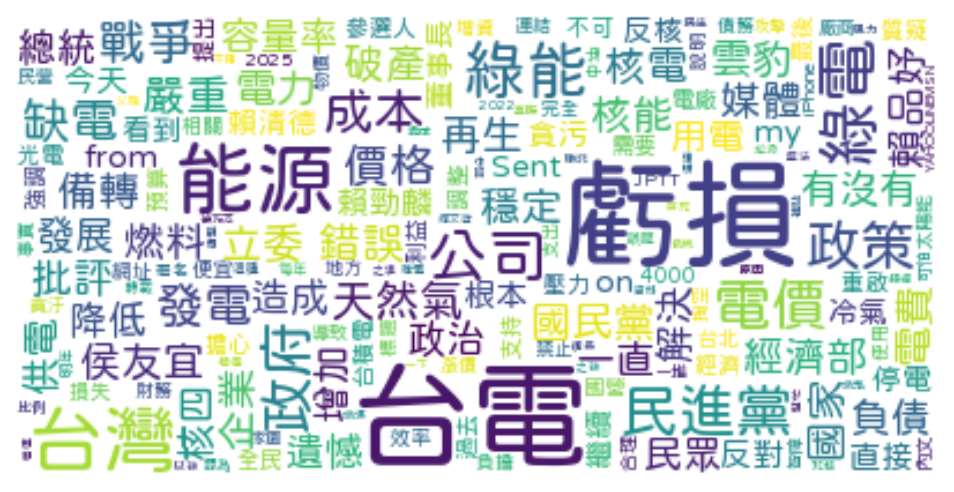

In [33]:
# wordcloud 的 input 是 dictionary
# 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=FontPath)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

篩選

(-0.5, 399.5, 199.5, -0.5)

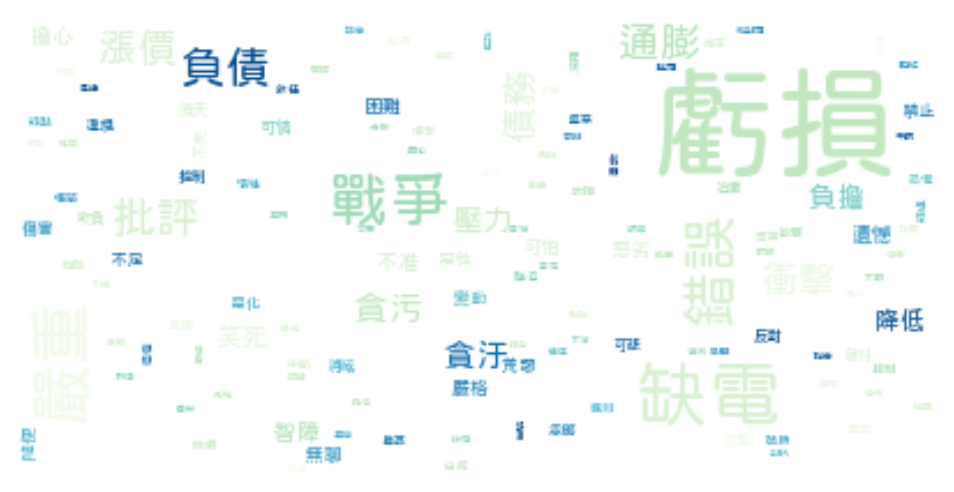

In [34]:
#找出特定區間的文章，這樣可以知道每一篇文章的「日期」與「情緒」
date = "2023-08-08"
end_date = "2023-08-16"
mask = (specific_date_sentiment_liwc_data['artDate'] >= pd.Timestamp(date).date()) & (
    specific_date_sentiment_liwc_data['artDate'] <= pd.Timestamp(end_date).date()) & (
    specific_date_sentiment_liwc_data['sentiment_class'] == "負向")

ptt_df_wc = specific_date_sentiment_liwc_data.loc[mask]
ptt_df_wc.head()
mask = (specific_date_sentiment_liwc_data['artDate'] >= pd.Timestamp(date).date()) & (
    specific_date_sentiment_liwc_data['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    specific_date_sentiment_liwc_data['sentiment_class'] == "負向")  & ( # 負面文章
    specific_date_sentiment_liwc_data['artContent'].str.contains('虧損')) & ( # 內文虧損
    specific_date_sentiment_liwc_data["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = specific_date_sentiment_liwc_data.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=FontPath, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

In [35]:
#找出特定區間的文章，這樣可以知道每一篇文章的「日期」與「情緒」
date = "2023-08-08"
end_date = "2023-08-16"
mask = (specific_date_sentiment_liwc_data['artDate'] >= pd.Timestamp(date).date()) & (
    specific_date_sentiment_liwc_data['artDate'] <= pd.Timestamp(end_date).date()) & (
    specific_date_sentiment_liwc_data['sentiment_class'] == "負向")

ptt_df_wc = specific_date_sentiment_liwc_data.loc[mask]
ptt_df_wc.head()
mask = (Sent_Seg_data['artDate'] >= pd.Timestamp(date).date()) & (
    Sent_Seg_data['artDate'] <= pd.Timestamp(end_date).date()) & (
    Sent_Seg_data['sentiment_class'] == "負向") & (
    Sent_Seg_data['artContent'].str.contains('虧損')) & (
    Sent_Seg_data['sentence'].str.contains('壓力')) # 包含「壓力」的句子

df_ = Sent_Seg_data.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(Sent_Seg_data), surrounding_indices)))

# 依據索引取得相應的資料
result_df = Sent_Seg_data.iloc[surrounding_indices].sort_index()
result_df

,system_id,artTitle,artDate,artContent,sentence,sentiment_class
75381,2169,[問卦]台電年終今年可以領8.8個月嗎?,2023-08-10,去年台電虧損2000億\n\n只是勉為其難的發了4.4個月的年終\n\n希望員工共體時艱\n...,去年台電虧損2000億,負向
75382,2169,[問卦]台電年終今年可以領8.8個月嗎?,2023-08-10,去年台電虧損2000億\n\n只是勉為其難的發了4.4個月的年終\n\n希望員工共體時艱\n...,只是勉為其難的發了44個月的年終,負向
75383,2169,[問卦]台電年終今年可以領8.8個月嗎?,2023-08-10,去年台電虧損2000億\n\n只是勉為其難的發了4.4個月的年終\n\n希望員工共體時艱\n...,希望員工共體時艱,負向
75384,2169,[問卦]台電年終今年可以領8.8個月嗎?,2023-08-10,去年台電虧損2000億\n\n只是勉為其難的發了4.4個月的年終\n\n希望員工共體時艱\n...,現在台電有可能虧到4000億,負向
75385,2169,[問卦]台電年終今年可以領8.8個月嗎?,2023-08-10,去年台電虧損2000億\n\n只是勉為其難的發了4.4個月的年終\n\n希望員工共體時艱\n...,兩年後至少要漲價45才能避免台電倒閉,負向
...,...,...,...,...,...,...
86897,2717,[新聞]台電：俄烏戰爭致燃料大漲核電比例高國,2023-08-15,1.媒體來源:\nCNA\n\n2.記者署名:\n曾智怡\n\n3.完整新聞標題:\n台電：...,同時,負向
86898,2717,[新聞]台電：俄烏戰爭致燃料大漲核電比例高國,2023-08-15,1.媒體來源:\nCNA\n\n2.記者署名:\n曾智怡\n\n3.完整新聞標題:\n台電：...,國內電價調整方案也盡量細緻化,負向
86899,2717,[新聞]台電：俄烏戰爭致燃料大漲核電比例高國,2023-08-15,1.媒體來源:\nCNA\n\n2.記者署名:\n曾智怡\n\n3.完整新聞標題:\n台電：...,以讓台電維持供電穩定任務的同時,負向
86900,2717,[新聞]台電：俄烏戰爭致燃料大漲核電比例高國,2023-08-15,1.媒體來源:\nCNA\n\n2.記者署名:\n曾智怡\n\n3.完整新聞標題:\n台電：...,兼顧照顧民,負向


# 去年台電虧損2000億

In [36]:
# 安裝會使用到的套件
# 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
# %pip install -U ckiptagger\[tf,gdown\]
# %pip install wordcloud SnowNLP

In [37]:
# # 確認當前工作目錄
# %pwd

In [38]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

In [39]:
# data_utils.download_data_gdown("./")  # 下載ckip model

# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("/Users/aiden/Downloads/data")
pos = POS("/Users/aiden/Downloads/data")
ner = NER("/Users/aiden/Downloads/data")

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2024-03-26 17:03:30.986972: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This cl

In [40]:
## 讀取文章
df = pd.read_csv('./Taipower230321_240321.csv')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1679328898....,[問卦]台電藏電是不是觸犯法律？,2023-03-21 00:14:56,Crosstrek,Gossiping,電是用納稅人繳的錢發的\n\n但是党說台電自行把電藏起來\n\n是否應該用非法侵占國有財產罪...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""cutesoda"", ""...",27.247.70.44,2023-03-21 01:41:59,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1679331364....,[問卦]誰不喜歡用便宜的電吃便宜的蛋,2023-03-21 00:56:02,ianlin1216,Gossiping,餓死抬頭\n最近看到不少奇怪言論\n像是台灣電價太便宜、缺蛋？還是缺錢？\n肥宅活到快30才...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""sustaining"",...",42.73.253.171,2023-03-21 01:42:18,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1679334621....,[問卦]風力0.05%？晚上90%的發電靠燃氣/,2023-03-21 01:50:19,M9665566,Gossiping,https://i.imgur.com/lGzIICD.jpg\n半夜看空氣霧霧的，想說一定...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""whiteadam"", ...",111.242.64.93,2023-03-22 01:33:04,ptt


In [41]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [42]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [43]:
df.dropna(subset=['artContent'], inplace=True)
pos_table, entity_table, sentence_table = get_nlp_result(df)  

time costing: 1691.2306020259857


In [44]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,電,Na
1,1,是,SHI
2,1,用,P
3,1,納稅人,Na
4,1,繳,VD


In [45]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,台電,ORG
1,2,台灣,NORP
2,3,半夜,TIME
3,3,台電,ORG
4,3,半夜,TIME


In [46]:
sentence_table.head()

,system_id,sentence
0,1,電是用納稅人繳的錢發的
1,1,但是党說台電自行把電藏起來
2,1,是否應該用非法侵占國有財產罪來法辦這些涉嫌藏電的台電員工
3,2,餓死抬頭
4,2,最近看到不少奇怪言論


In [47]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1628篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1620篇有抓到ner

total posts numbers: 5377
posts have NER: 5041


In [49]:
# 將文章存成csv
pos_table.to_csv('./ckiptable/pos_table_buffet.csv', index = False)
entity_table.to_csv('./ckiptable/entity_table_buffet.csv', index = False)
sentence_table.to_csv('./ckiptable/sentence_table_buffet.csv', index = False)

In [52]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("./ckiptable/pos_table_buffet.csv") 
entity_table = pd.read_csv("./ckiptable/entity_table_buffet.csv") 
sentence_table = pd.read_csv("./ckiptable/sentence_table_buffet.csv") 

In [53]:
entity_table['ner'].unique()

array(['ORG', 'NORP', 'TIME', 'CARDINAL', 'DATE', 'QUANTITY', 'PERSON',
       'FAC', 'GPE', 'ORDINAL', 'MONEY', 'EVENT', 'LAW', 'PERCENT', 'LOC',
       'LANGUAGE', 'PRODUCT', 'WORK_OF_ART'], dtype=object)

In [54]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

,ner,count
11,ORG,23082
13,PERSON,18227
4,GPE,15614
1,DATE,11195
0,CARDINAL,5730
3,FAC,2811
8,MONEY,2743
16,TIME,2069
7,LOC,1732
9,NORP,1596


/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/3390866936.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


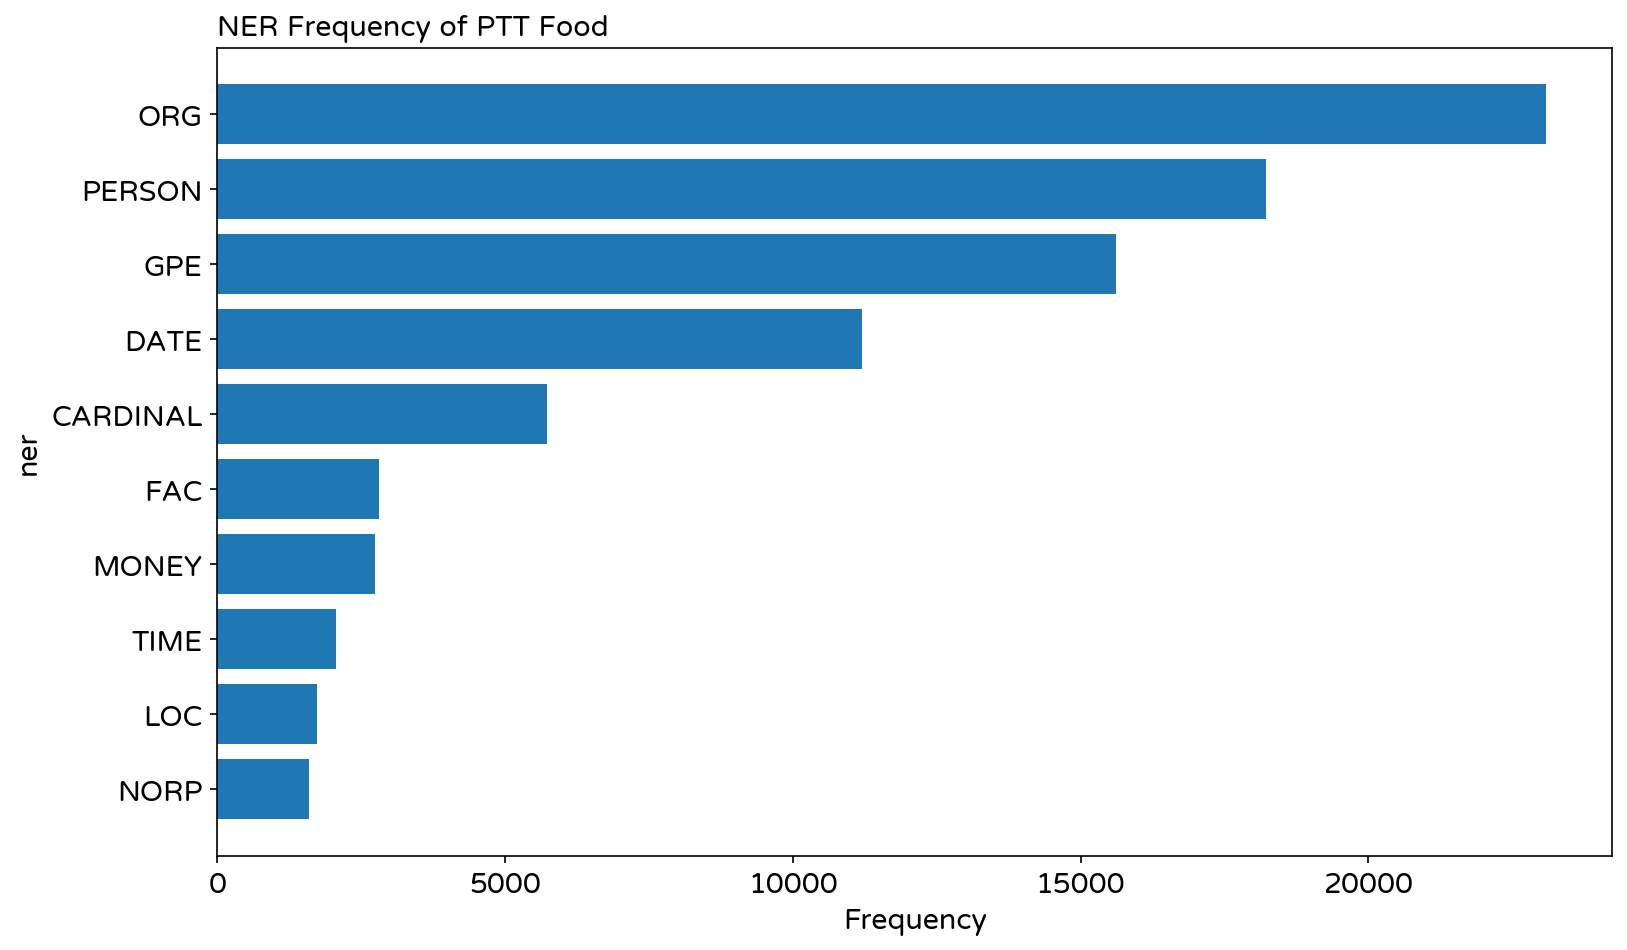

In [55]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/1728269046.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


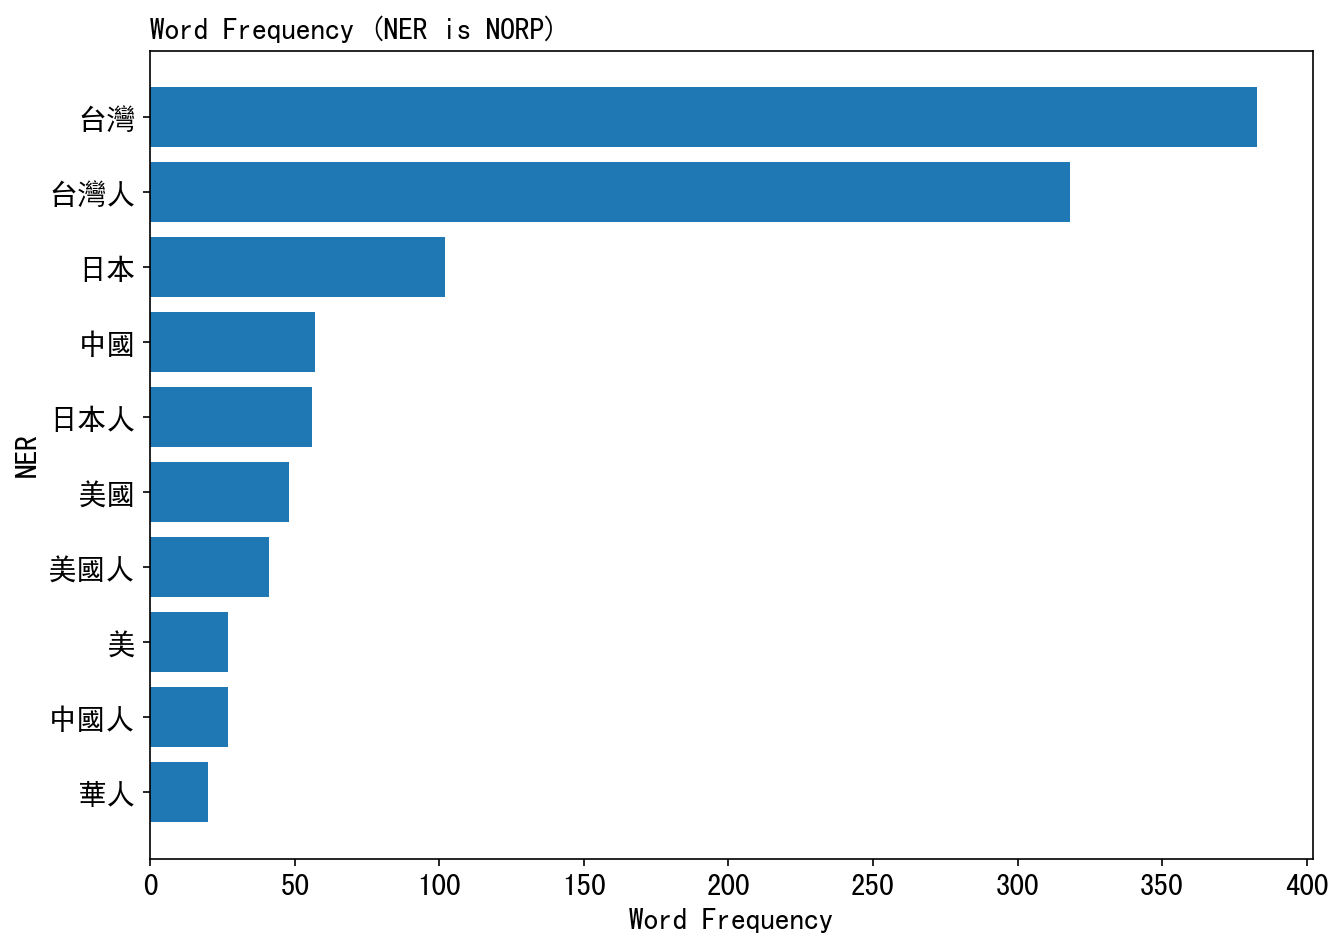

In [56]:
# 篩選ner為NORP的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/3046915581.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


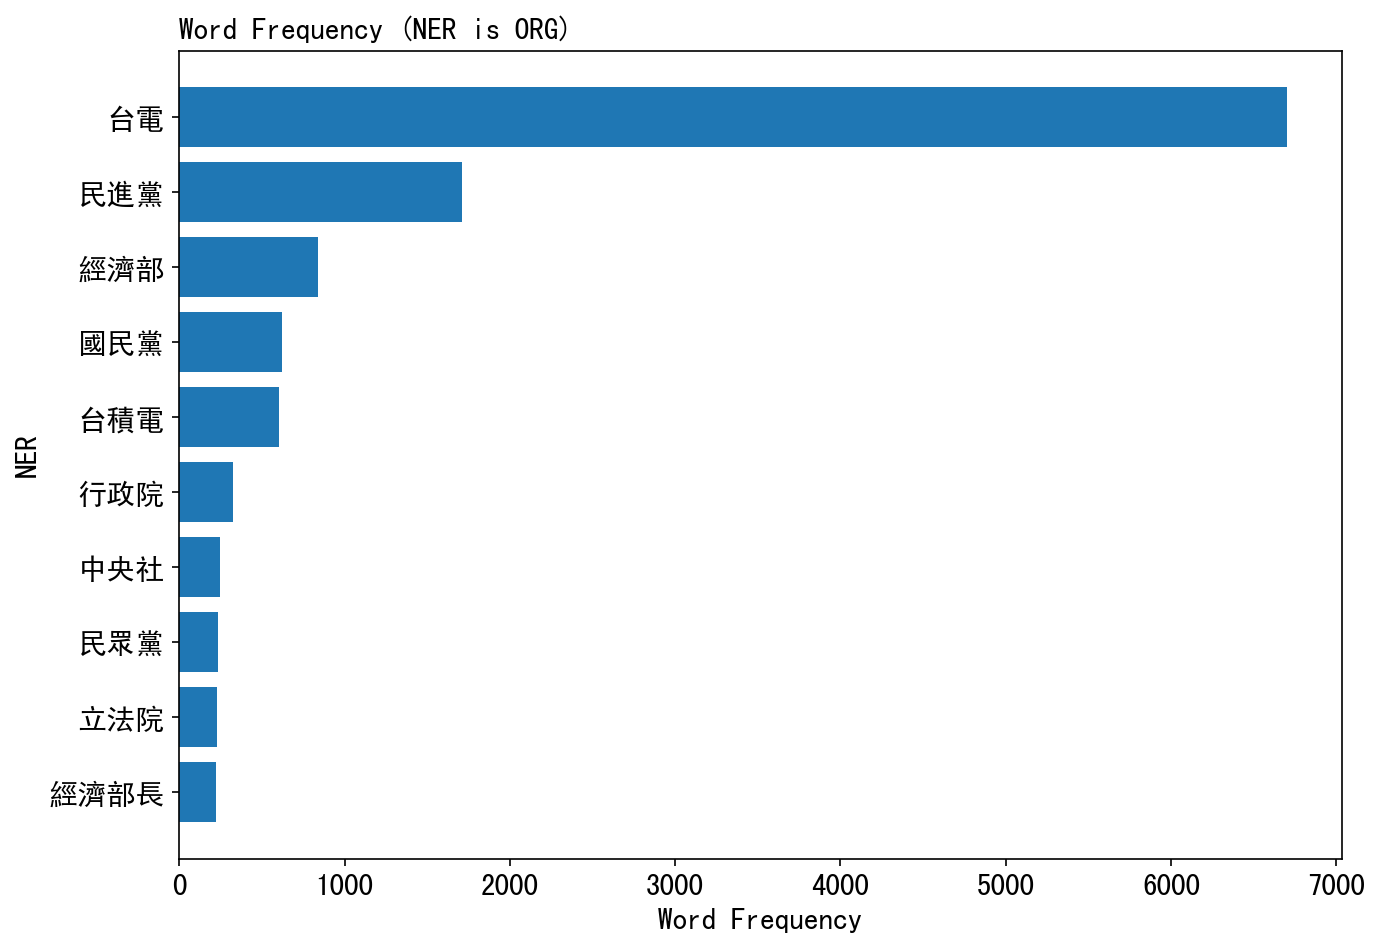

In [57]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/3088262201.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


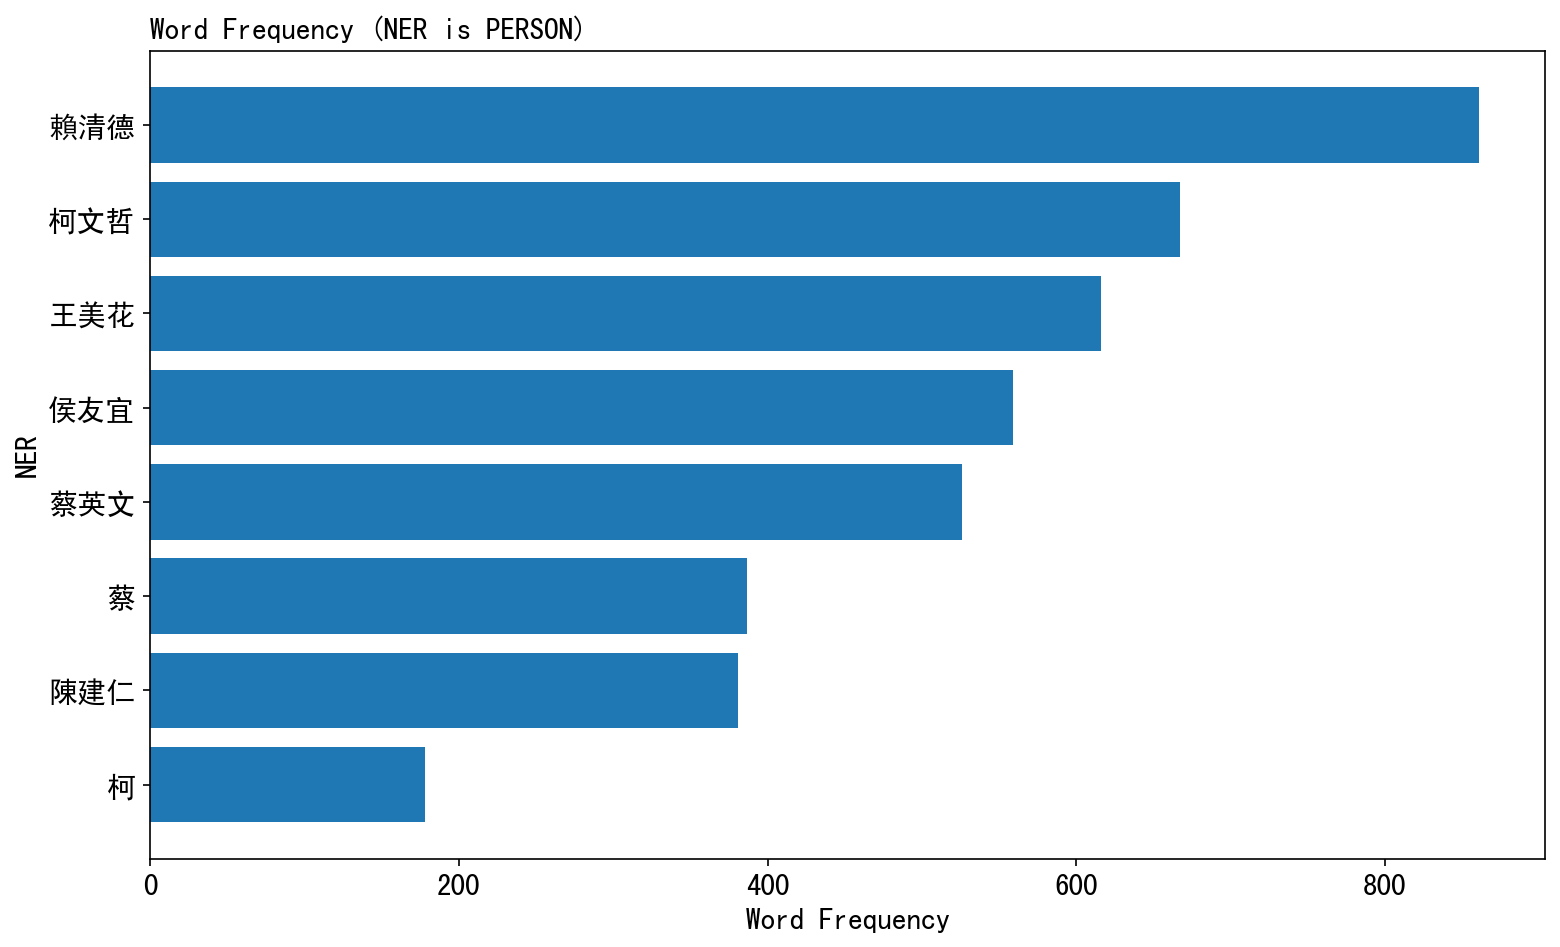

In [58]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [59]:
keyword_list = ['王美花']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)

王美花：191篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
19,20,https://www.ptt.cc/bbs/Gossiping/M.1679369898....,[新聞]為社子停電道歉王美花：積極盤點汰換老,2023-03-21 11:38:16,talasuw,Gossiping,1.媒體來源:\n中央社\n\n2.記者署名:\n劉千綾\n\n3.完整新聞標題:\n為社子...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",39.9.207.61,2023-03-22 01:35:23,ptt
29,30,https://www.ptt.cc/bbs/Gossiping/M.1679391322....,[新聞]電價漲！靠綠能分攤「核二2號機」 專家,2023-03-21 17:35:18,andy199113,Gossiping,1.媒體來源: TVBS\n2.記者署名: 記者 林莉 / 攝影 徐國衡 報導\n3.完整新...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""rb731024"", ""...",36.227.16.175,2023-03-22 01:38:41,ptt
32,33,https://www.ptt.cc/bbs/Gossiping/M.1679396241....,[新聞]缺蛋缺水又停電 陳建仁狂讚：陳吉仲、,2023-03-21 18:57:18,deathdecay,Gossiping,中廣新聞\n\n記者 李人岳報導\n\n缺蛋缺水又停電 陳建仁狂讚：陳吉仲、王美花很適任\n...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""BlueBird5566...",1.163.55.6,2023-03-22 01:39:24,ptt


In [60]:
pos_table['pos'].unique()

array(['Na', 'SHI', 'P', 'VD', 'DE', 'Cbb', 'VE', 'Nc', 'D', 'VC', 'Di',
       'A', 'VB', 'Neqa', 'VK', 'VA', 'VHC', 'Nd', 'VH', 'Dfa', 'VJ',
       'Da', 'V_2', 'VG', 'Nf', 'Caa', 'VCL', 'Nep', 'FW', 'T',
       'COMMACATEGORY', 'Nh', 'Ng', 'Ncd', 'Neu', 'Nes', 'Dk', 'Nb', 'VF',
       'Nv', 'Cab', 'VI', 'Dfb', 'VL', 'VAC', 'I', 'PERIODCATEGORY',
       'Cba', 'Neqb', 'PARENTHESISCATEGORY', 'COLONCATEGORY', 'DM',
       'ETCCATEGORY', 'SEMICOLONCATEGORY', 'DOTCATEGORY'], dtype=object)

In [61]:
#看看除了標點符號，大部分的POS都是哪一類
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
17,Na,270346
5,D,134858
38,VC,95025
44,VH,78077
19,Nc,69232
31,P,43455
6,DE,41981
41,VE,36756
35,VA,29297
27,Nf,28907


/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


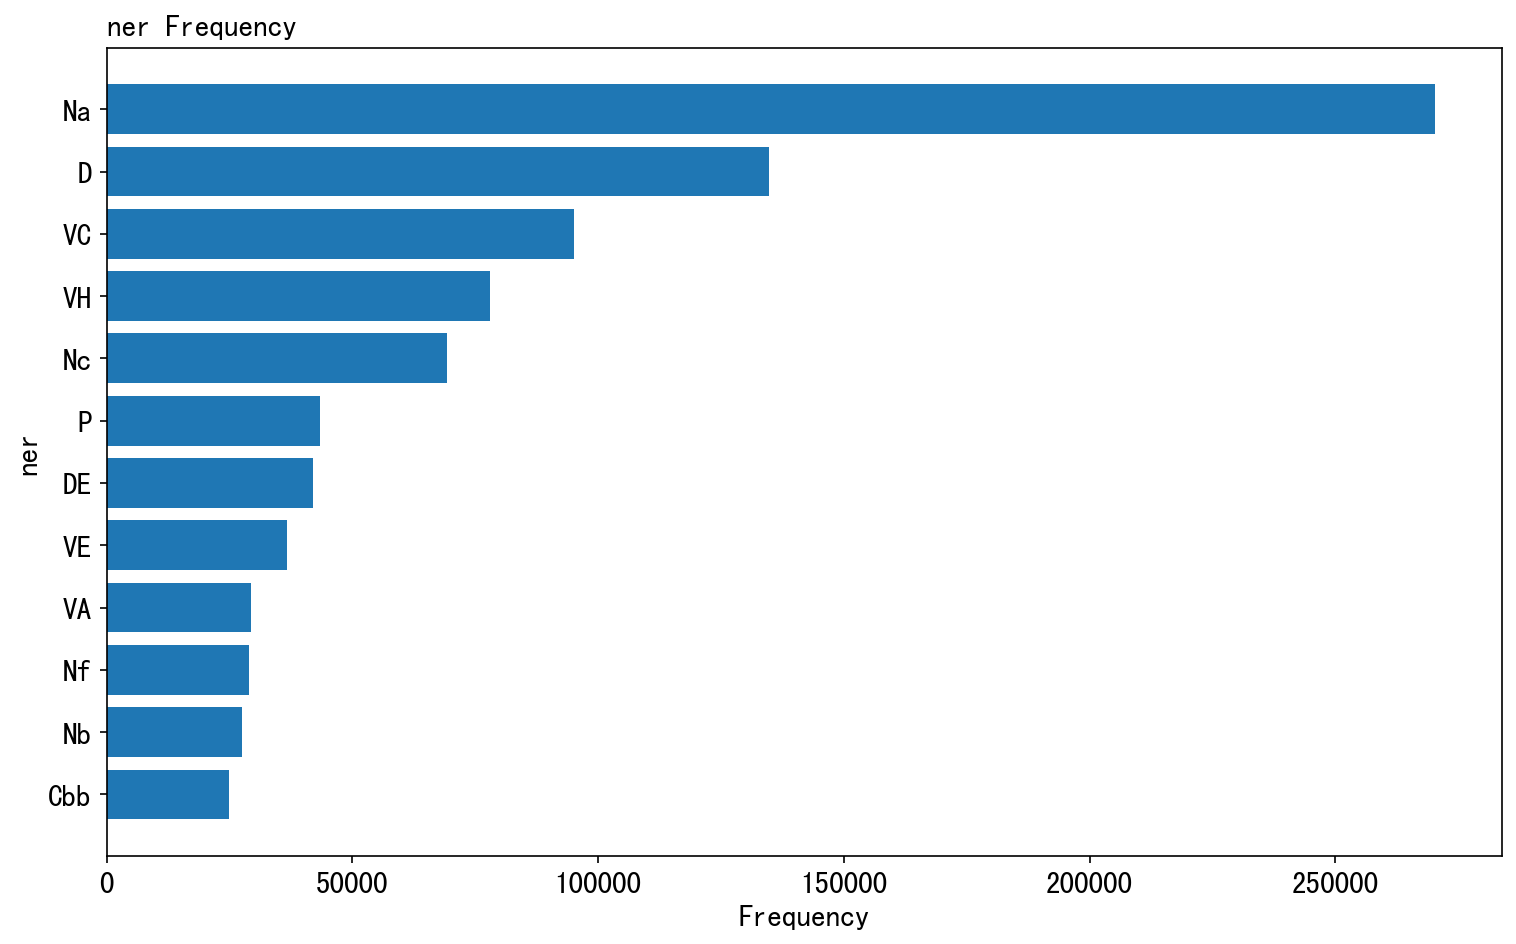

In [62]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

In [63]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
2712,民進黨,1735
4344,賴清德,875
590,台積電,682
2464,柯文哲,670
888,國民黨,659
3133,王美花,628
214,侯友宜,563
3941,蔡英文,528
3872,蔡,389
5009,陳建仁,382


/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/502700507.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


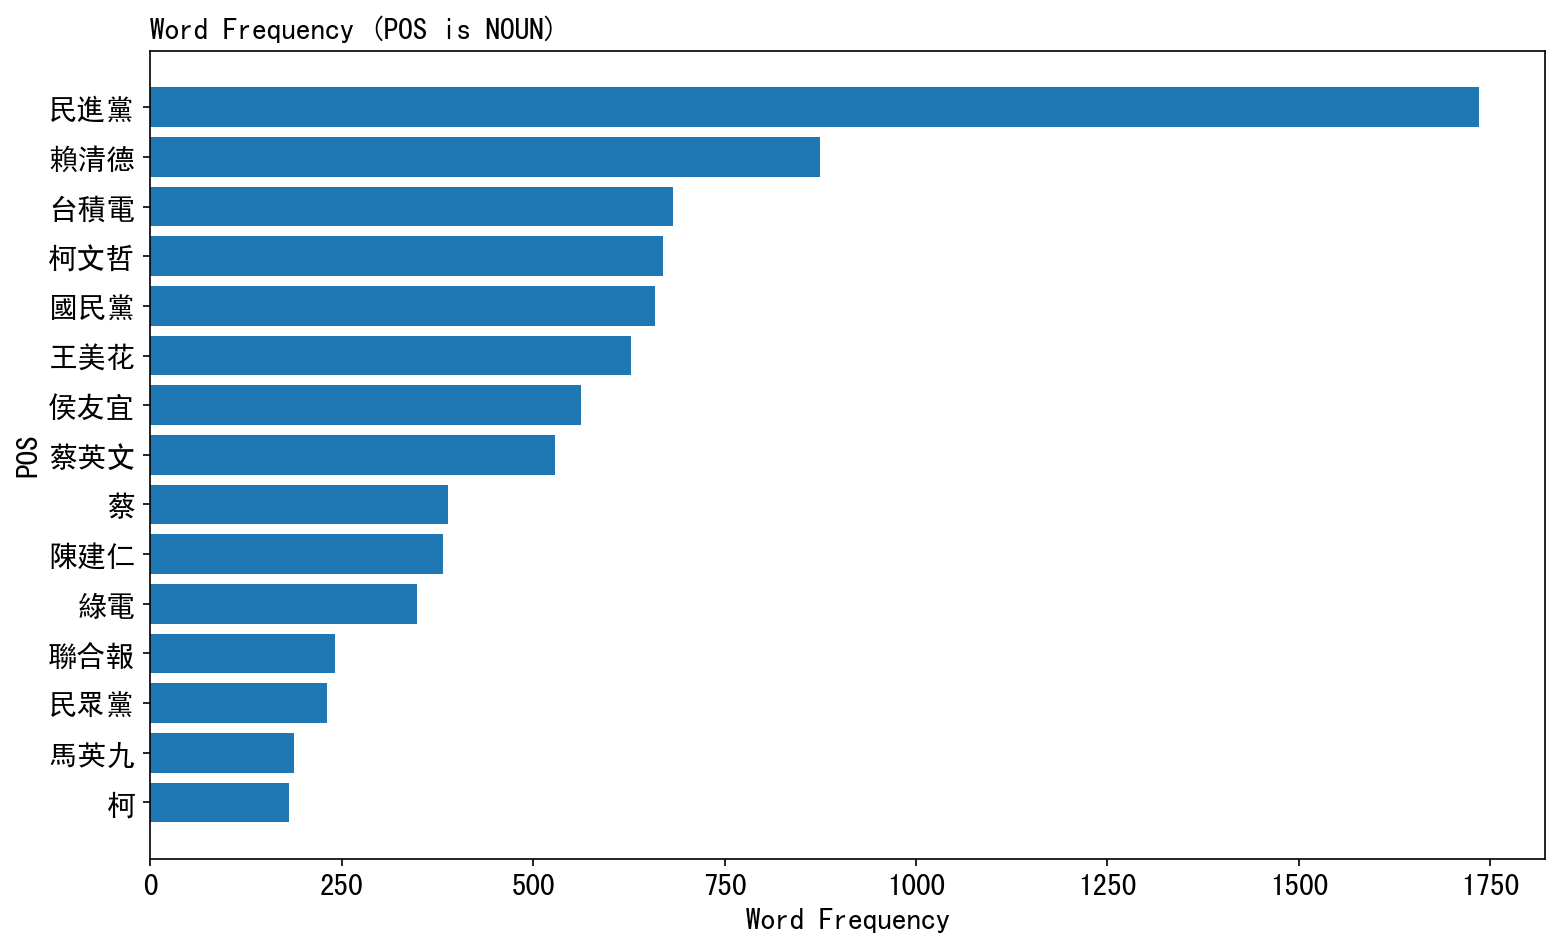

In [64]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [65]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
5296,調漲,1267
4161,發展,979
5786,連結,967
211,使用,940
5290,調整,908
4712,署名,883
1851,影響,806
5665,轉載,785
5801,進行,653
4940,處理,580


/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/2587760616.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


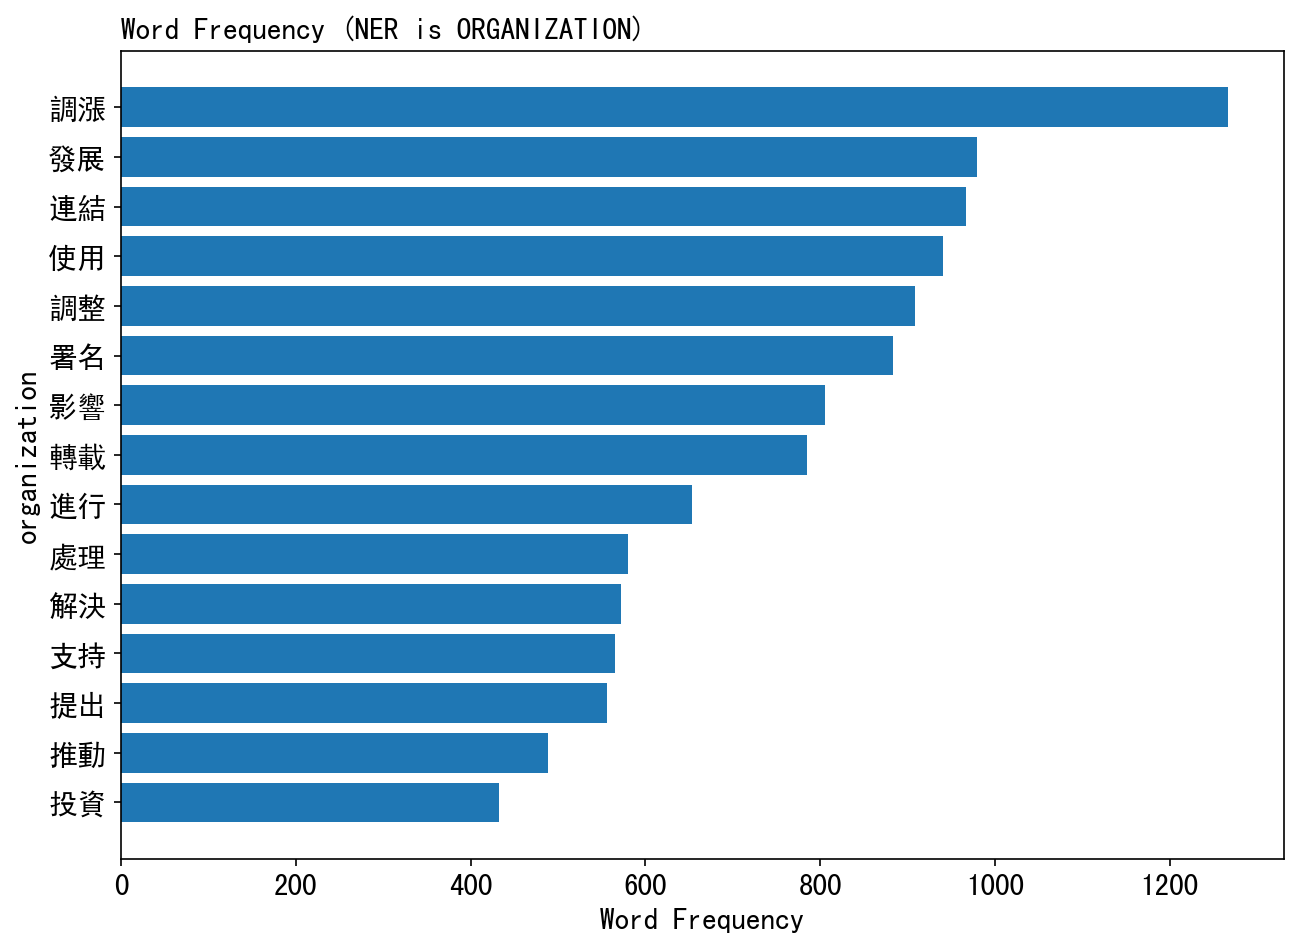

In [66]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [67]:
from snownlp import SnowNLP

In [69]:
sentence_table = pd.read_csv("./ckiptable/sentence_table_buffet.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource
651,20,媒體來源,2023-03-21 11:38:16,ptt
652,20,中央社,2023-03-21 11:38:16,ptt
653,20,記者署名,2023-03-21 11:38:16,ptt


In [70]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource,sentimentValue
651,20,媒體來源,2023-03-21 11:38:16,ptt,0.219627
652,20,中央社,2023-03-21 11:38:16,ptt,0.170663
653,20,記者署名,2023-03-21 11:38:16,ptt,0.729795


In [71]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    8.693000e+03
mean     3.815364e-01
std      3.232358e-01
min      2.775755e-10
25%      7.220122e-02
50%      3.221936e-01
75%      6.264225e-01
max      9.999979e-01
Name: sentimentValue, dtype: float64

<Axes: >

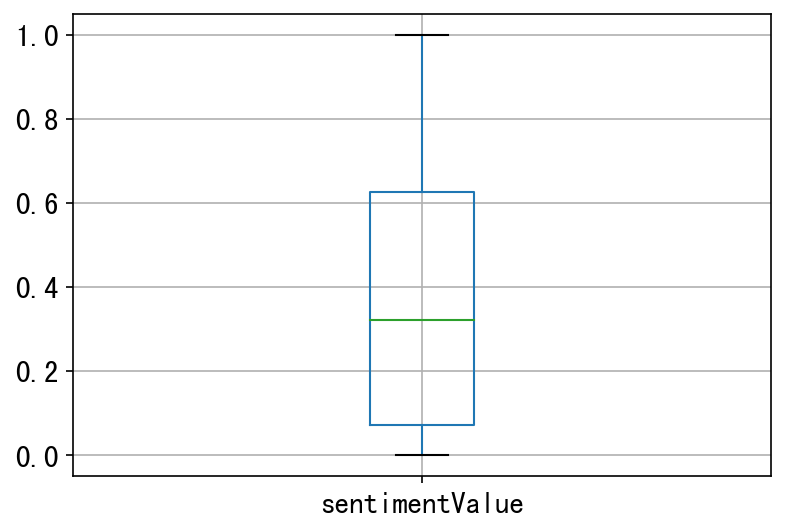

In [72]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [73]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2023-03,0.394103
1,2023-04,0.384438
2,2023-05,0.429419
3,2023-06,0.420121
4,2023-07,0.375569
5,2023-08,0.372079
6,2023-09,0.342227
7,2023-10,0.373900
8,2023-11,0.394055
9,2023-12,0.360878


/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_25271/857956447.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


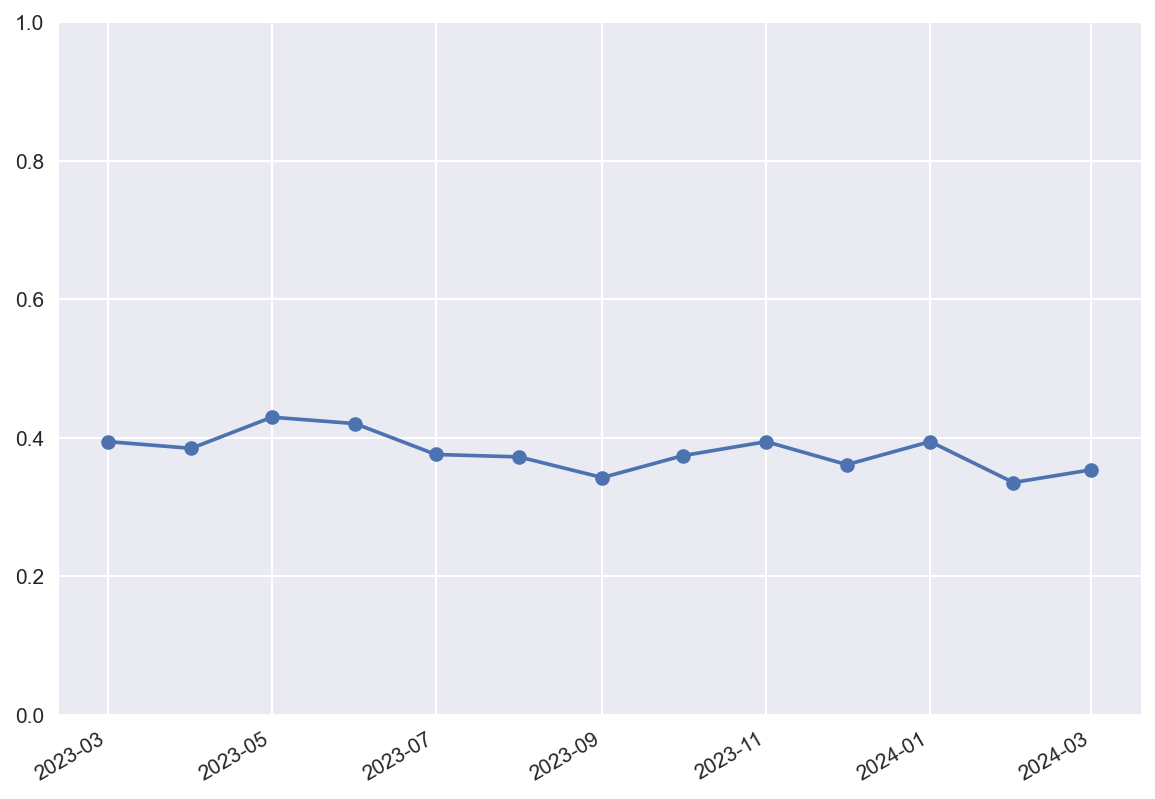

In [74]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

In [82]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2024-02']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
105171,4224,王美花談核能延役交由新民意新政府決定,2024-02,ptt,0.890408
105174,4224,經濟部今日舉行年終記者會，會中經濟部長王美花表示，現在新民意組成的立法院,2024-02,ptt,0.932360
105177,4224,經濟部今日舉行年終記者會，會中經濟部長王美花表示，現在新民意組成的立法院,2024-02,ptt,0.932360
105182,4224,興起核電應該要延役，讓核電廠持續使用,2024-02,ptt,0.733399
105183,4224,經濟部長王美花表示，近期台電持續擴充相關,2024-02,ptt,0.951353


In [83]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

,system_id,sentimentValue,word
0,4224,0.890408,媒體
1,4224,0.890408,來源
2,4224,0.890408,風傳
3,4224,0.890408,媒
4,4224,0.890408,記者


In [84]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

In [85]:
# 自定停用字
with open('./dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

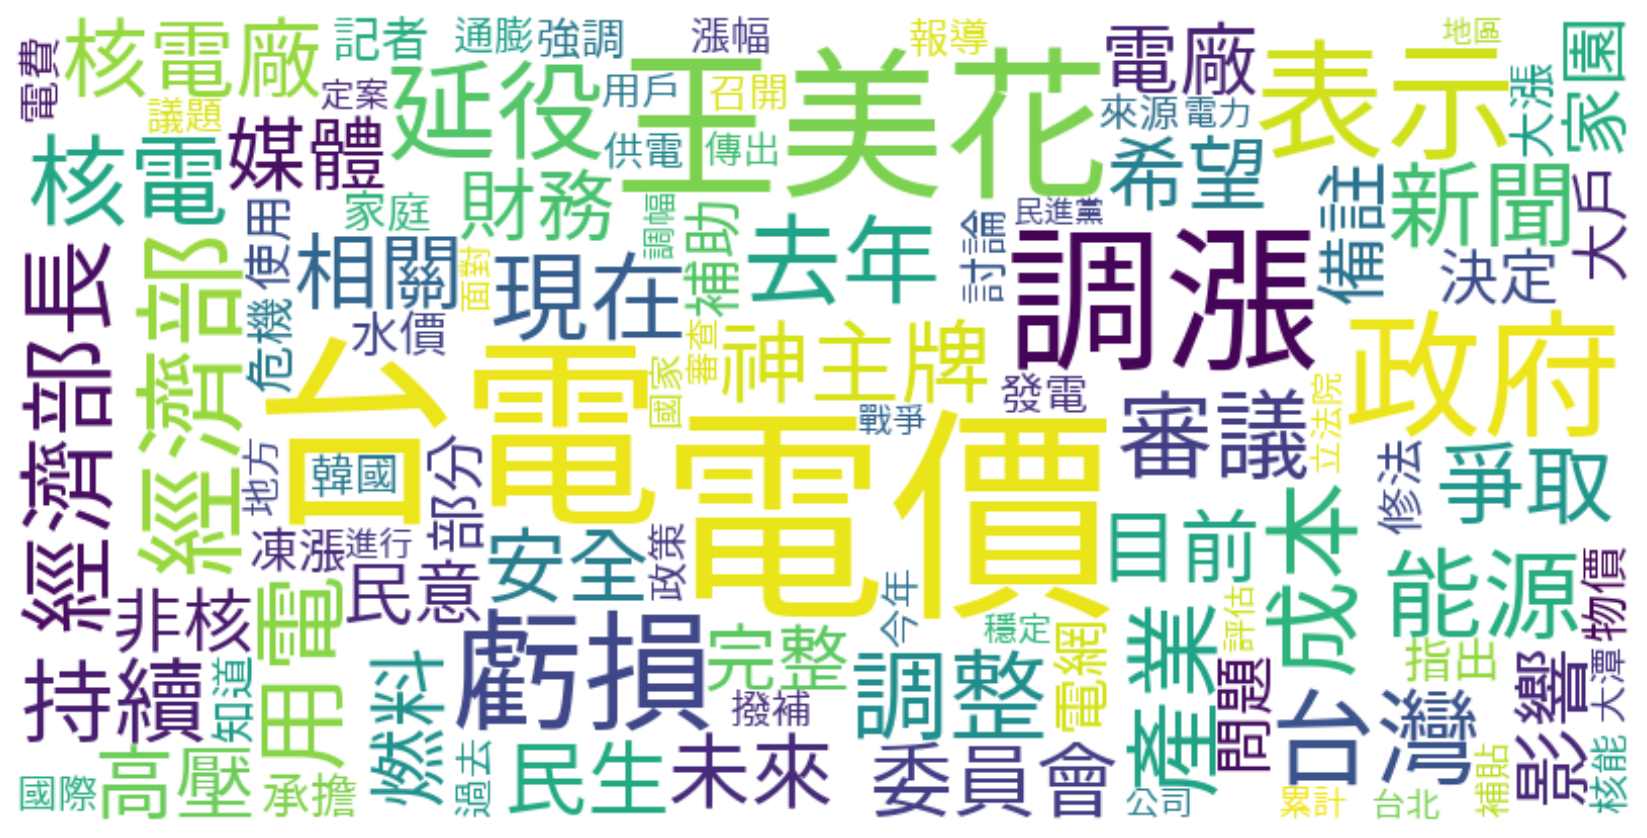

In [86]:
# 匯入自訂的 stop words
stop_words_pos = stop_words
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()